In [1]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

load_dotenv()

# Initialize Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# Test prompt
# response = llm.invoke("What is LangGraph in one sentence?")

c:\Users\harsh\Desktop\My space\Projects 2025\perplexicity-clone\server\perplexvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
search_tool = TavilySearchResults(max_results=4)

# response = search_tool.invoke("what is the weather in Ahmedabad?")
# response
tools = [search_tool]   

memory = MemorySaver() 

C:\Users\harsh\AppData\Local\Temp\ipykernel_7532\161181813.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=4)


In [3]:
llm_with_tools = llm.bind_tools(tools)

In [4]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
    
async def model(state: State):
    print("Running model with messages:", state["messages"])
    result = await llm_with_tools.ainvoke(state["messages"])
    print("Model result:", result)
    return {
        "messages": state["messages"] + [result],
    }
    
async def tools_router(state: State):
    last_message = state["messages"][-1]
    print("Router received message:", last_message)

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        print("Tool calls found:", last_message.tool_calls)
        return "tool_node"
    else:
        print("No tool calls. Ending.")
        return END

    
async def tool_node(state):
    tool_calls = state["messages"][-1].tool_calls
    tool_messages = []

    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        # Parse tool_args if necessary
        if isinstance(tool_args, str):
            try:
                tool_args = json.loads(tool_args)
            except:
                from ast import literal_eval
                tool_args = literal_eval(tool_args)

        print("Tool Calls:", tool_calls)

        if tool_name == "tavily_search_results_json":
            search_results = await search_tool.ainvoke(tool_args)
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            tool_messages.append(tool_message)

    return {
        "messages": state["messages"] + tool_messages
    }


graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges(
    "model",
    tools_router,
    {
        "tool_node": "tool_node",
        "__end__": END,
    })

graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

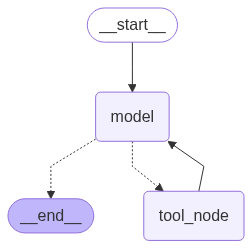

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API
        )
    )
)


In [6]:
# config = {
# "configurable": 
#     {
#         "thread_id": "5"
#     }
# }

# response = await graph.ainvoke({
#     "messages":[HumanMessage(content="what were my last 2 questions?")],
# }, config=config)

# response
# print("Response:", response["messages"][1].content)


In [9]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

Running model with messages: [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='8e83afd1-a430-4c8a-b09c-4c8976c6040c')]
Model result: content='' additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "next SpaceX launch date"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--469d4276-9d8f-4ba3-acc9-1361651a1d26-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch date'}, 'id': '7dee6524-97c1-4a97-8584-8a03607d4e55', 'type': 'tool_call'}] usage_metadata={'input_tokens': 82, 'output_tokens': 24, 'total_tokens': 168, 'input_token_details': {'cache_read': 0}}
Router received message: content='' additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "next SpaceX launch date"}'}} response_metadata={'prompt_feedback': {'block

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='8e83afd1-a430-4c8a-b09c-4c8976c6040c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "next SpaceX launch date"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--469d4276-9d8f-4ba3-acc9-1361651a1d26-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch date'}, 'id': '7dee6524-97c1-4a97-8584-8a03607d4e55', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 24, 'total_tokens': 168, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{\'title\': \'SpaceX Launch Schedule - RocketLaunch.Live\', \'url\': \'https://www.rocketlaunch.live/?filter=spacex\', \'content\': \'| Selected |\\n| --- |\\n| Providers | all |\\n| Locations | al

In [12]:
# config = {
#     "configurable": {
#     "thread_id": 6
#     }
# }
# # Use async for to iterate over the async generator
# async for event in graph.astream_events({
#     "messages": [HumanMessage(content="Give me a 100 word essay on climate change")],
# },config=config, version="v2"):
#     if event["event"] == "on_chat_model_stream" :
#         print(event ["data"] ["chunk"]. content, end="", flush=True)


config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="Give 100 word essay on climate change")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Give 100 word essay on climate change', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '588c4e66-2408-4861-8be8-763343455ffa', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='6c80c5e3-93a9-4e5a-b38e-9ede7c80d7e7'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "next SpaceX launch date"}'}}, response_metadata={'finish_reason': 'STOP', 'safety_ratings': []}, id='run--4a8f41e7-9c98-43db-843e-346b6c5624e4', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch date'}, 'id': '14409f83-440f-44c7-832f-2f55fb5f39ef', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 24, 'tota

In [ ]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)